In [1]:
import numpy as np
from EmbedSeg.utils.create_dicts import create_test_configs_dict
from EmbedSeg.test import begin_evaluating
from glob import glob
import tifffile
import matplotlib.pyplot as plt
from EmbedSeg.utils.visualize import visualize_im_pred
import os
from matplotlib.colors import ListedColormap
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import date
today = date.today()
today = today.strftime("%b-%d-%Y")

### Specify the path to the evaluation images

In [3]:
data_dir = '../../../data'
project_name = 'basel-2020'
print("Evaluation images shall be read from: {}".format(os.path.join(data_dir, project_name)))

Evaluation images shall be read from: ../../../data/basel-2020


### Specify evaluation parameters 

Some hints:
* `tta`: Setting this to True (default) would enable **test-time augmentation**
* `ap_val`: This parameter ("average precision value") comes into action if ground truth segmentations exist for evaluation images, and allows to compare how good our predictions are versus the available ground truth segmentations.
* `seed_thresh`: This parameter ("seediness threshold") allows considering only those pixels as potential instance-centres which have a seediness score greater than `seed_thresh`
* `min_object_size`: This parameter ("minimum object size") allows considering only those predicted instances which have more interior pixels than `min_object_size` 
* `checkpoint_path`: This parameter provides the path to the trained model weights which you would like to use for evaluation
* `save_dir`: This parameter specifies the path to the prediction instances. Equal to `static` by default.
* `save_images`: If True, this saves predictions at `static/predictions/` 
* `save_results`: If True, this saves results at `static/results/`
* `normalization_factor`: Set this to either 255 (for 8-bit raw-images) or 65535 (for 16-bit instance-images). This parameter should be **set the same value** as `normalization_factor` used while creating `train_dataset_dict` and `val_dataset_dict` during training.
* `one_hot`: In case, ground truth segmentations exist for evaluation images, then set this parameter to `True` if the GT segmentations are present in a one-hot encoded style (i.e. each object is encoded as 1 in its own individual slice and 0 elsewhere) or `False`, otherwise

In the cell after this one, a `test_configs` dictionary is generated from the parameters specified here!

In [4]:
tta = False
ap_val = 0.5
seed_thresh = 0.8
min_object_size = 36
checkpoint_path = os.path.join('experiment', 'basel-2020-Jan-03-2021', 'best_iou_model.pth')
save_dir = 'static'
save_images = True
save_results = True
normalization_factor = 1
one_hot = False
grid_y = 1024
grid_x = 1024

In [5]:
if os.path.exists(checkpoint_path):
    print("Trained model weights found at : {}".format(checkpoint_path))
else:
    print("Trained model weights were not found at the specified location!")

Trained model weights found at : experiment/basel-2020-Jan-03-2021/best_iou_model.pth


### Create `test_configs` dictionary from the above-specified parameters

In [6]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        ap_val = ap_val,
                                        seed_thresh = seed_thresh, 
                                        min_object_size = min_object_size, 
                                        save_images = save_images,
                                        save_results = save_results,
                                        save_dir = save_dir,
                                        normalization_factor = normalization_factor,
                                        one_hot = one_hot,
                                        grid_y = grid_y,
                                        grid_x = grid_x,
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../../data/basel-2020, 
 -- trained weights accessed from experiment/basel-2020-Jan-03-2021/best_iou_model.pth, 
 -- seediness threshold set at 0.8, 
 -- output directory chosen as static


### Begin Evaluating

Setting `verbose` to True shows you Average Precision at IOU threshold specified by `ap_val` above for each individual image.

In [7]:
%matplotlib agg
begin_evaluating(test_configs, verbose = False)

2-D `test` dataloader created! Accessing data from ../../../data/basel-2020/test/
Number of images in `test` directory is 17
Number of instances in `test` directory is 17
Number of center images in `test` directory is 0
*************************
Creating branched erfnet with [4, 1] classes


100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

Mean Average Precision at IOU threshold = 0.5, is equal to 0.88910


### Test on more unseen images

<div class="alert alert-warning">
Specify below the path to the image which you would like to evaluate!
</div>

In [8]:
im_numpy = tifffile.imread('/media/manan/Samsung_T51/Manan/EmbedSeg_RC/data/basel-2020/test/images/X_9.tif')

The following two cells simply push the image to the GPU and load the model with the trained weights. Simply press <kbd>Shift</kbd> + <kbd>Enter</kbd> on them.

In [9]:
import torch
import torch.nn.functional as F
from EmbedSeg.models import get_model
from EmbedSeg.utils.utils import Cluster
device = torch.device("cuda:0" if test_configs['cuda'] else "cpu")
model = get_model(test_configs['model']['name'], test_configs['model']['kwargs'])
model = torch.nn.DataParallel(model).to(device)
state = torch.load(test_configs['checkpoint_path'])
model.load_state_dict(state['model_state_dict'], strict=True)

Creating branched erfnet with [4, 1] classes


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [10]:
cluster = Cluster(grid_y, grid_x, 1, 1)
im = torch.from_numpy(im_numpy[np.newaxis, np.newaxis, ...]).float().cuda()
if im.ndimension()==5:
    instance_map = []
    for z in range(im.shape[2]):
        im_z = im[:, :, z, ...]
        multiple_y = im_z.shape[2] // 8
        multiple_x = im_z.shape[3] // 8

        if im_z.shape[2] % 8 != 0:
            diff_y = 8 * (multiple_y + 1) - im_z.shape[2]
        else:
            diff_y = 0
        if im_z.shape[3] % 8 != 0:
            diff_x = 8 * (multiple_x + 1) - im_z.shape[3]
        else:
            diff_x = 0
        p2d = (diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2)

        im_z = F.pad(im_z, p2d, "constant", 0)
        output = model(im_z)
        instance_map_z, predictions_z = cluster.cluster(prediction = output[0])

        instance_map.append(instance_map_z.unsqueeze(0))
       
       
    instance_map=torch.cat(instance_map).cpu().detach().numpy()

### Load a new pre-saved color map!

In [11]:
%matplotlib inline
new_cmp= np.load('../../../cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

<div class="alert alert-warning">
Feel free to re-run the following cell multiple times to look at random time frames! <br>
On the left is the image and the right is the prediction by the trained model.
</div>

Showing time point = 69


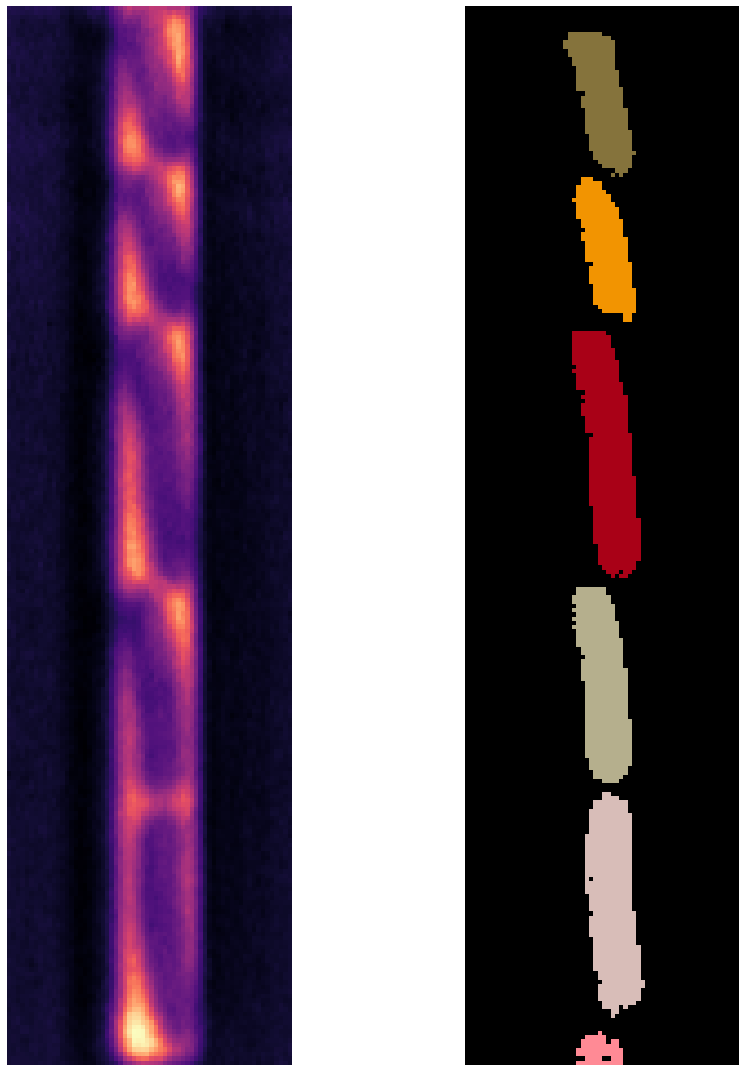

In [20]:
z = np.random.randint(im_numpy.shape[0])
print("Showing time point = {}".format(z))
visualize_im_pred(im_numpy[z][diff_y // 2: -(diff_y - diff_y // 2), :], instance_map[z], new_cmp)